In [1]:
# Imports

import numpy as np
import logging; logger = logging.getLogger(__name__)


from opendrift.models.oceandrift import OceanDrift, Lagrangian3DArray
from opendrift.models.leeway import Leeway # For Search and Rescure. May not be relevant
from opendrift.models.plastdrift import PlastDrift
from opendrift.models.sedimentdrift import SedimentDrift # Looks most promising
from opendrift.models.radionuclides import Radionuclide

from opendrift.readers import reader_netCDF_CF_generic

from pprint import pprint
from opendrift.readers import reader_global_landmask

from datetime import datetime

from opendrift.models.basemodel import OpenDriftSimulation
from opendrift.elements import LagrangianArray


### Getting number and position of particles
Using data for fishing activity over the timespan 2021-2022 to estimate the placement and number of particles released. Count any activity over half an hour, then release another particle for every 10 hours of activity. Can change this number.

In [2]:
import pandas as pd

# Imported data from excel sheets
fishing_activity = pd.read_csv("Fishing_activity_2021-2022.csv", delimiter=';', header=0,usecols=[0,1,3,4], low_memory=False)
fishing_activity = fishing_activity[fishing_activity['geartype'] == 'set_gillnets']
fishing_activity = fishing_activity.rename({'Lat': 'lat', 'Lon': 'lon', 'Apparent Fishing hours': 'fishing_hours'}, axis=1)

fishing_activity['fishing_minutes'] = (fishing_activity['fishing_hours'] * 60).astype(int)

# Filter out fishing activity under 0.5 hours:
fishing_activity = fishing_activity[fishing_activity['fishing_hours'] > 0.5]
fishing_activity['n_particles'] = fishing_activity['fishing_hours']//10+1

# Only southern Norway (South of Namsos)
fishing_activity = fishing_activity[fishing_activity['lat'] < 64]

# Repeat n_particles times
repeated = fishing_activity.loc[fishing_activity.index.repeat(fishing_activity['n_particles'])]
init_lats = repeated['lat'].values
init_lons = repeated['lon'].values

In [7]:
init_lats

array([60.1 , 58.35, 63.7 , ..., 63.02, 62.93, 62.99])

In [9]:
init_lons.shape

(14980,)

lats_total and lons_total are the coordinates of the particles being released. Where multiple particles should be placed in the same spot, there are multiples of the same latitude and longitude.

### Seeding elements
To seed an element simply means releasing it into the ocean (for simulation). <br>

**Important:**
- If `lon` and `lat` are given as arrays of two elements, the GhostNet is dropped randomly at the line between them. Here, the radius can incorporate the uncertainty of the line's width. 
- If `time` is given as an array, then the GhostNet is dropped randomly in the timeinterval. 

In [3]:
from random import randrange
from datetime import timedelta

def random_date(start, end):
    """
    This function will return a random datetime between two datetime 
    objects.
    """
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    return start + timedelta(seconds=random_second)

start_date = datetime.strptime('1/1/2021', '%m/%d/%Y')
end_date = datetime.strptime('1/1/2023', '%m/%d/%Y')

sim_start = random_date(start_date, end_date)
sim_start

datetime.datetime(2021, 12, 5, 0, 16, 13)

In [4]:
# These are the standard arguments. 
# number GhostNet is dropped at longitude 4.3, lattitude 60 within a radius of 1000 meters. 
#o.seed_elements(lon=4.5, lat=60, radius=1000, number=10, time=reader_norkyst.start_time)

# Generic reader
reader_norkyst = reader_netCDF_CF_generic.Reader(
    filename='https://thredds.met.no/thredds/dodsC/sea/norkyst800m/1h/aggregate_be'
)

# Landmask reader. 
reader_landmask = reader_global_landmask.Reader()

14:02:24 DEBUG   opendrift.models.basemodel:618: Adding 17 config items from basemodel
14:02:24 DEBUG   opendrift.models.basemodel:618: Adding 5 config items from basemodel
14:02:24 DEBUG   opendrift.models.basemodel:618: Adding 22 config items from basemodel
14:02:24 INFO    opendrift.models.basemodel:532: OpenDriftSimulation initialised (version 1.10.6)
14:02:24 DEBUG   opendrift.models.basemodel:618: Adding 14 config items from oceandrift
14:02:24 DEBUG   opendrift.models.basemodel:630:   Overwriting config item seed:z
14:02:24 DEBUG   opendrift.models.basemodel:618: Adding 1 config items from plastdrift
14:02:24 INFO    opendrift.readers.reader_netCDF_CF_generic:138: Opening dataset: https://thredds.met.no/thredds/dodsC/sea/norkyst800m/1h/aggregate_be
14:02:48 DEBUG   opendrift.readers.reader_netCDF_CF_generic:155: Finding coordinate variables.
14:02:49 DEBUG   opendrift.readers.reader_netCDF_CF_generic:355: Skipped variables without standard_name: ['angle', 'tke', 'ubar', 'vbar']


In [6]:
o = PlastDrift()
o.set_config('general:coastline_action', 'stranding')

o.add_reader([reader_landmask, reader_norkyst])

o.seed_elements(lon=init_lats, lat=init_lons, time=sim_start)

o.run(time_step=3600,steps=24, stop_on_error=True)

14:03:26 DEBUG   opendrift.models.oceandrift:112: No machine learning correction available.
14:03:26 DEBUG   opendrift.models.basemodel:618: Adding 17 config items from basemodel
14:03:26 DEBUG   opendrift.models.basemodel:618: Adding 5 config items from basemodel
14:03:26 DEBUG   opendrift.models.basemodel:618: Adding 22 config items from basemodel
14:03:26 INFO    opendrift.models.basemodel:532: OpenDriftSimulation initialised (version 1.10.6)
14:03:26 DEBUG   opendrift.models.basemodel:618: Adding 14 config items from oceandrift
14:03:26 DEBUG   opendrift.models.basemodel:630:   Overwriting config item seed:z
14:03:26 DEBUG   opendrift.models.basemodel:618: Adding 1 config items from plastdrift
14:03:26 DEBUG   opendrift.models.basemodel:945: Added reader global_landmask
14:03:26 DEBUG   opendrift.readers.basereader.variables:546: Setting buffer size 7 for reader https://thredds.met.no/thredds/dodsC/sea/norkyst800m/1h/aggregate_be, assuming a maximum average speed of 1 m/s and time 

In [13]:
print(o)

--------------------
Reader performance:
--------------------
global_landmask
 0:00:00.1  total
 0:00:00.0  preparing
 0:00:00.1  reading
 0:00:00.0  masking
--------------------
global_landmask_0
 0:00:00.1  total
 0:00:00.0  preparing
 0:00:00.1  reading
 0:00:00.0  masking
--------------------
global_landmask_0_0
 0:00:00.1  total
 0:00:00.0  preparing
 0:00:00.1  reading
 0:00:00.0  masking
--------------------
https://thredds.met.no/thredds/dodsC/sea/norkyst800m/1h/aggregate_be
--------------------
Performance:
   42.5 total time
   40.2 configuration
    0.1 preparing main loop
      0.0 moving elements to ocean
      1.6 readers
        0.2 global_landmask
        1.1 postprocessing
    2.9 main loop
      0.2 updating elements
    0.1 cleaning up
--------------------
Model:	PlastDrift     (OpenDrift version 1.10.6)
	1 active PlastElement particles  (0 deactivated, 1 scheduled)
-------------------
Environment variables:
  -----
  land_binary_mask
     1) global_landmask
     2) 

13:53:16 DEBUG   opendrift.models.basemodel:3168: Setting up map: corners=None, fast=False, lscale=None
13:53:16 DEBUG   opendrift.readers.reader_global_landmask:83: Adding GSHHG shapes from cartopy, scale: i, extent: (56.32000122070311, 64.3900016784668, 2.169999885559082, 11.290000152587886)..
13:53:27 DEBUG   opendrift.readers.reader_global_landmask:83: Adding GSHHG shapes from cartopy, scale: i, extent: (56.32000122070311, 64.3900016784668, 2.169999885559082, 11.290000152587886)..
13:53:30 DEBUG   opendrift.readers.reader_global_landmask:83: Adding GSHHG shapes from cartopy, scale: i, extent: (56.32000122070311, 64.3900016784668, 2.169999885559082, 11.290000152587886)..


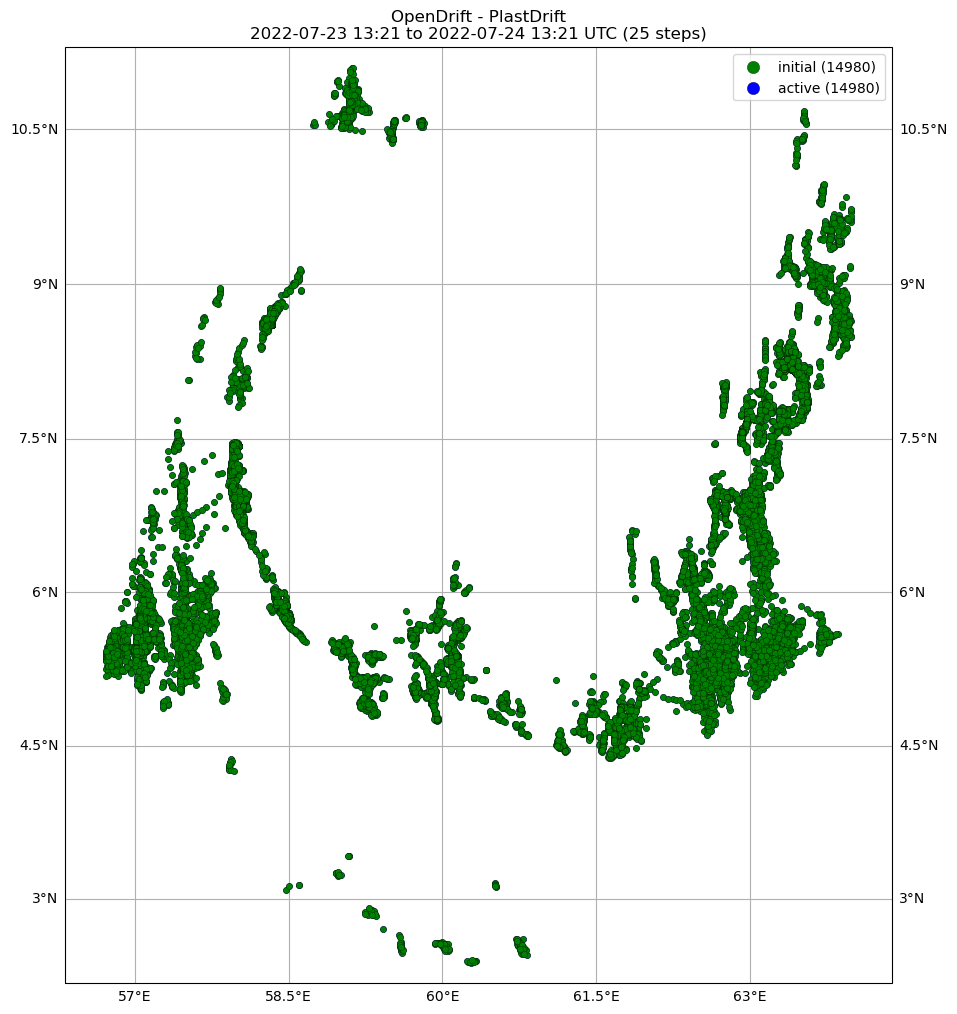

(<GeoAxes: title={'center': 'OpenDrift - PlastDrift\n2022-07-23 13:21 to 2022-07-24 13:21 UTC (25 steps)'}>,
 <Figure size 966.648x1100 with 1 Axes>)

In [7]:
o.plot()

Can save the simulation data to file on .nc format.

In [ ]:
# Importing data for simulation instead of running it again.

# o = PlastDrift(loglevel=0)
# o.io_import_file('sim_1_day.nc')

11:59:31 DEBUG   opendrift.models.basemodel:3168: Setting up map: corners=None, fast=False, lscale=None
11:59:31 DEBUG   opendrift.readers.reader_global_landmask:83: Adding GSHHG shapes from cartopy, scale: i, extent: (1.7949088573455814, 11.489600563049317, 56.51133041381834, 64.36349792480468)..
11:59:45 DEBUG   opendrift.readers.reader_global_landmask:83: Adding GSHHG shapes from cartopy, scale: i, extent: (1.7949088573455814, 11.489600563049317, 56.51133041381834, 64.36349792480468)..
11:59:50 DEBUG   opendrift.readers.reader_global_landmask:83: Adding GSHHG shapes from cartopy, scale: i, extent: (1.7949088573455814, 11.489600563049317, 56.51133041381834, 64.36349792480468)..


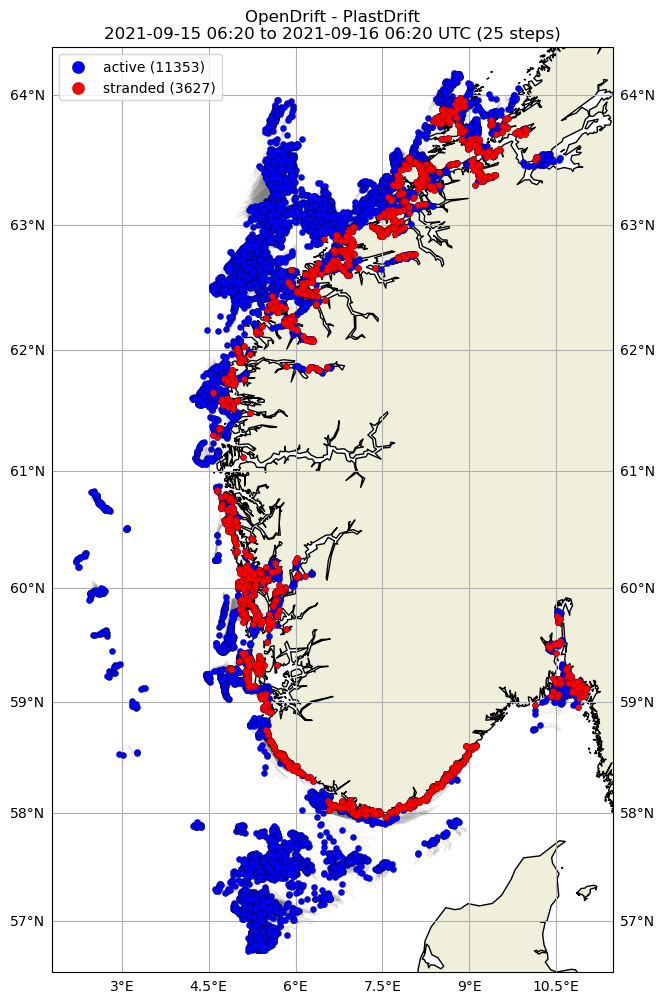

(<GeoAxes: title={'center': 'OpenDrift - PlastDrift\n2021-09-15 06:20 to 2021-09-16 06:20 UTC (25 steps)'}>,
 <Figure size 670.06x1100 with 1 Axes>)

In [128]:
o.plot(show_initial=False)

In [154]:
# Using netCDF4

import netCDF4 as nc
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [224]:
ds = nc.Dataset('sim_100_days.nc')
lons = ds.variable['lon'][:]
lats = ds.variable['lats'][:]

start_pos = pd.DataFrame({'lat': lats[:, 0], 'lons': lons[:, 0]})
end_pos = pd.DataFrame({'lat': lats[:, -1], 'lons': lons[:, -1]})

AttributeError: NetCDF: Attribute not found

In [155]:
lon_active, lat_active = o.elements.lon.data, o.elements.lat.data
lon_deactive, lat_deactive = o.elements_deactivated.lon.data, o.elements_deactivated.lat.data

active_points = pd.DataFrame({'lat': lat_active, 'lon': lon_active})
deactive_points = pd.DataFrame({'lat': lat_deactive, 'lon': lon_deactive})

In [159]:
fig = px.scatter_mapbox(active_points, lat='lat', lon='lon', mapbox_style='open-street-map')

fig.add_trace(go.Scattermapbox(
    lat=deactive_points['lat'],
    lon=deactive_points['lon']
))
fig.update_layout(title = 'Congregation of nets', title_x=0.5)
fig.show()

In [161]:
%pip install scikit-learn

  Using cached scikit_learn-1.2.2-cp311-cp311-macosx_10_9_x86_64.whl (9.0 MB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
Note: you may need to restart the kernel to use updated packages.


In [184]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(kernel='gamma', bandwidth=0.5).fit(deactive_points)

InvalidParameterError: The 'kernel' parameter of KernelDensity must be a str among {'linear', 'gaussian', 'exponential', 'epanechnikov', 'cosine', 'tophat'}. Got 'gamma' instead.

In [177]:
fig = px.scatter_mapbox(deactive_points, lat='lat', lon='lon', color=np.exp(kde.score_samples(deactive_points)), mapbox_style='open-street-map')
fig.show()